In [3]:
import os
import pretty_midi
import numpy as np
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:

# Path to the directory containing MIDI files
base_dir = './Composer_Dataset/NN_midi_files_extended/train'


# List of folders (composers) within the base directory
composer_folders = os.listdir(base_dir)

# Initialize a list to store all loaded MIDI data
all_midi_data = []

# Function to load MIDI files from the specified directory
def load_midi_files(base_dir):
    # Loop through each composer folder
    for composer_folder in composer_folders:
        composer_path = os.path.join(base_dir, composer_folder)
        
        # Check if the item in the base directory is a folder
        if os.path.isdir(composer_path):
            print(f"Loading MIDI files from {composer_folder}...")
            
            # Loop through each MIDI file in the composer folder
            for file_name in os.listdir(composer_path):
                file_path = os.path.join(composer_path, file_name)
                
                # Check if the item in the composer folder is a file and has a .mid or .midi extension
                if os.path.isfile(file_path) and (file_name.endswith('.mid')):
                    midi_data = pretty_midi.PrettyMIDI(file_path)
                    all_midi_data.append({
                        'composer': composer_folder,
                        'file_name': file_name,
                        'midi_data': midi_data
                    })
                    print(f"  Loaded: {file_name}")

    print("All MIDI files loaded successfully!")
    return all_midi_data

# Load all MIDI files from the specified directory
all_midi_data = load_midi_files(base_dir)


Loading MIDI files from bach...
  Loaded: bach342.mid
  Loaded: bach343.mid
  Loaded: bach345.mid
  Loaded: bach346.mid
  Loaded: bach347.mid
  Loaded: bach350.mid
  Loaded: bach351.mid
  Loaded: bach352.mid
  Loaded: bach353.mid
  Loaded: bach355.mid
  Loaded: bach357.mid
  Loaded: bach358.mid
  Loaded: bach360.mid
  Loaded: bach361.mid
  Loaded: bach362.mid
  Loaded: bach363.mid
  Loaded: bach364.mid
  Loaded: bach365.mid
  Loaded: bach366.mid
  Loaded: bach367.mid
  Loaded: bach368.mid
  Loaded: bach369.mid
  Loaded: bach370.mid
  Loaded: bach371.mid
  Loaded: bach372.mid
  Loaded: bach373.mid
  Loaded: bach374.mid
  Loaded: bach375.mid
  Loaded: bach377.mid
  Loaded: bach378.mid
  Loaded: bach379.mid
  Loaded: bach380.mid
  Loaded: bach381.mid
  Loaded: bach382.mid
  Loaded: bach383.mid
  Loaded: bach385.mid
  Loaded: bach386.mid
  Loaded: bach387.mid
  Loaded: bach388.mid
  Loaded: bach389.mid
  Loaded: bach390.mid
  Loaded: bach391.mid
Loading MIDI files from bartok...
  Loaded: 

C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  Loaded: chopin052.mid
  Loaded: chopin054.mid
  Loaded: chopin055.mid
  Loaded: chopin056.mid
  Loaded: chopin057.mid
  Loaded: chopin058.mid
  Loaded: chopin059.mid
  Loaded: chopin060.mid
  Loaded: chopin063.mid
  Loaded: chopin064.mid
  Loaded: chopin065.mid
  Loaded: chopin067.mid
  Loaded: chopin068.mid
  Loaded: chopin071.mid
  Loaded: chopin072.mid
  Loaded: chopin073.mid
  Loaded: chopin074.mid
  Loaded: chopin075.mid
  Loaded: chopin076.mid
  Loaded: chopin077.mid
  Loaded: chopin079.mid
  Loaded: chopin080.mid
  Loaded: chopin081.mid
  Loaded: chopin082.mid
  Loaded: chopin083.mid
  Loaded: chopin084.mid
  Loaded: chopin085.mid
  Loaded: chopin088.mid
  Loaded: chopin089.mid
  Loaded: chopin090.mid
  Loaded: chopin091.mid
  Loaded: chopin092.mid
  Loaded: chopin093.mid
  Loaded: chopin094.mid
  Loaded: chopin095.mid
  Loaded: chopin096.mid
  Loaded: chopin097.mid
  Loaded: chopin098.mid
Loading MIDI files from handel...
  Loaded: handel099.mid
  Loaded: handel100.mid
  Load

# Feature Engineering

In [4]:

# Initialize lists to store extracted features
num_instruments_list = []
instruments_list_list = []
num_programs_list = []
tempo_list = []
composer_list = []
resolution_list = []
time_signature_ratio_list = []
duration_list = []
average_pitch_list = []

# Function to extract features from MIDI data
def feature_extraction(midi_data):
    # Loop through all loaded MIDI data
    for data in all_midi_data:
        midi_data = data['midi_data']
        
        # Extract the number of instruments
        num_instruments = len(midi_data.instruments)
        num_instruments_list.append(num_instruments)
        
        # Extract the list of instruments
        instruments_list = [instrument.program for instrument in midi_data.instruments]
        # flatten the list
        instruments_list_list.append(instruments_list)
        
        # Extract the number of programs
        num_programs = len(set(instruments_list))
        num_programs_list.append(num_programs)
        
        # Extract the tempo
        tempo = midi_data.estimate_tempo()
        tempo_list.append(tempo)
        
        # Extract the composer name
        composer = data['composer']
        composer_list.append(composer)

        # resolution
        resolution = midi_data.resolution
        resolution_list.append(resolution)

        #time_signature_ratio- Take numerator and denominator of time signature and divide them
        if len(midi_data.time_signature_changes) <=0:
            time_signature_ratio = 0
            time_signature_ratio_list.append(time_signature_ratio)
        else:
            time_sig_numerator =  midi_data.time_signature_changes[0].numerator
            time_sig_denominator = midi_data.time_signature_changes[0].denominator
            time_signature_ratio = time_sig_numerator/time_sig_denominator
            time_signature_ratio_list.append(time_signature_ratio)

        # duration
        duration = midi_data.get_end_time()
        duration_list.append(duration)

        # average_pitch
        pitch_list = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                pitch_list.append(note.pitch)
        average_pitch = np.mean(pitch_list)
        average_pitch_list.append(average_pitch)


    # # Create a DataFrame to store the extracted features
    import pandas as pd
    df = pd.DataFrame({
        'composer': composer_list,
        'num_instruments': num_instruments_list,
        'instruments_list': instruments_list_list,
        'num_programs': num_programs_list,
        'tempo': tempo_list,
        'resolution': resolution_list,
        'time_signature_ratio': time_signature_ratio_list,
        'duration': duration_list,
        'average_pitch': average_pitch_list
    })

    return df

# Extract features from the loaded MIDI data
df = feature_extraction(all_midi_data)
print('Feature extraction complete!')
df.head()

Feature extraction complete!


,composer,num_instruments,instruments_list,num_programs,tempo,resolution,time_signature_ratio,duration,average_pitch
0,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,248.235754,384,1.0,914.875000,63.972681
1,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,233.938023,384,0.0,445.690104,67.986739
2,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,266.035285,384,1.0,89.213542,64.177885
3,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,230.553293,384,1.0,103.048177,64.491651
4,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,175.318569,384,1.0,91.907552,62.205387


# Data Exploration

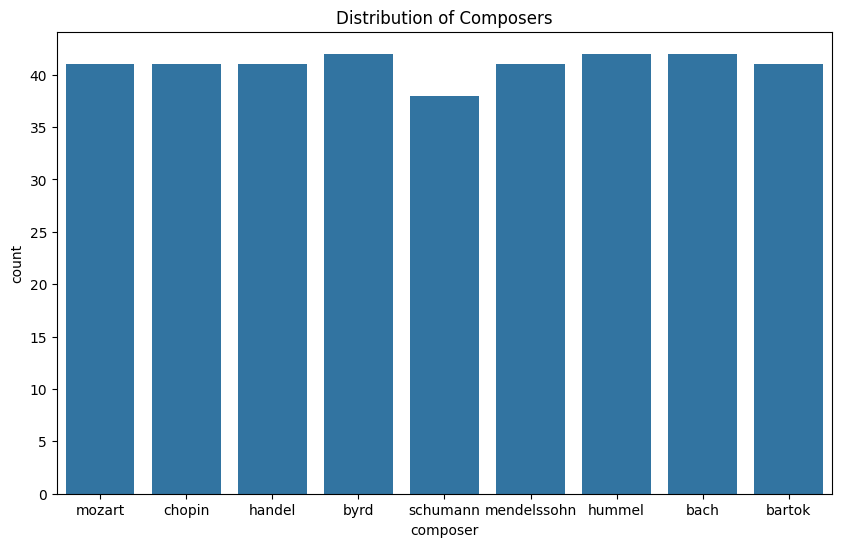

In [4]:
# Display the number of unique composers
df['composer'].value_counts()

# Display the distribution of composers
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer')
plt.title('Distribution of Composers')
plt.show()


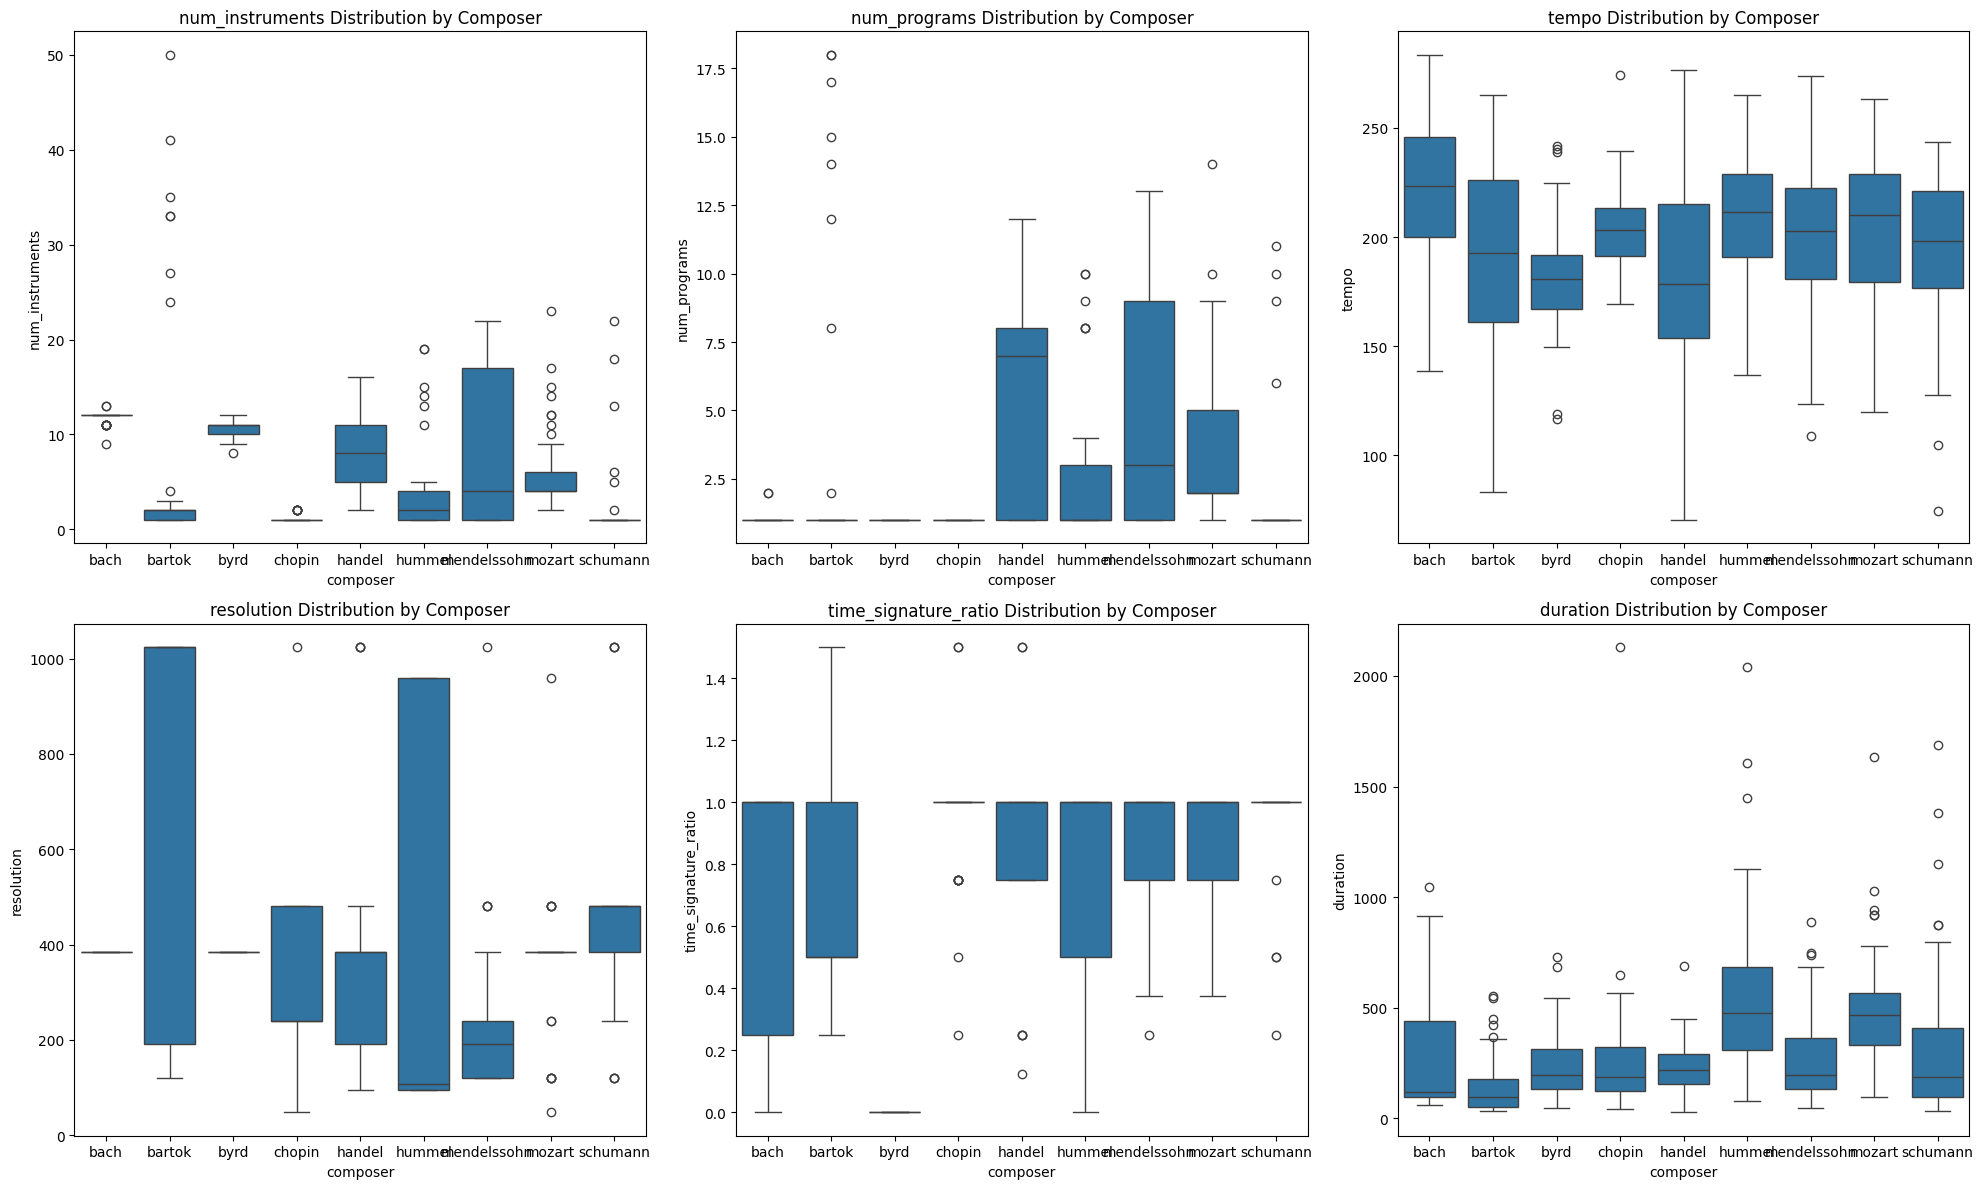

In [6]:
# Create a list of features to plot
features = ['num_instruments', 'num_programs', 'tempo', 'resolution', 'time_signature_ratio', 'duration', 'average_pitch']

# Plot the feature distributions side by side 
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i, feature in enumerate(features):
    if feature == 'average_pitch':
        continue
    sns.boxplot(data=df, x='composer', y=feature, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'{feature} Distribution by Composer')
plt.tight_layout()
plt.show()




# Preprocessing

In [7]:
# Outlier Removal
from scipy.stats import zscore

# Calculate the z-scores of each feature in the DataFrame
z_scores = df[features].apply(zscore)

# Find the indices of rows with outliers
outlier_indices = z_scores[(z_scores > 3).any(axis=1)].index

# Remove rows with outliers
df_clean = df.drop(outlier_indices)

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)
print(f"Number of rows in the cleaned dataset: {num_rows_clean}")

# loop through each feature and check for outliers
for feature in features:
    # Calculate the first and third quartiles
    q1 = df_clean[feature].quantile(0.25)
    q3 = df_clean[feature].quantile(0.75)
    
    # Calculate the interquartile range
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Find the indices of rows with outliers
    outlier_indices = df_clean[(df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)].index
    
    # Remove rows with outliers
    df_clean = df_clean.drop(outlier_indices)
    
    # Display the number of rows removed
    num_outliers = len(outlier_indices)
    
    print(f"Removed {num_outliers} outliers from the dataset for {feature}")

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)

print(f"Number of rows in the cleaned dataset: {num_rows_clean}")



Number of rows in the cleaned dataset: 353
Removed 0 outliers from the dataset for num_instruments
Removed 71 outliers from the dataset for num_programs
Removed 5 outliers from the dataset for tempo
Removed 33 outliers from the dataset for resolution
Removed 0 outliers from the dataset for time_signature_ratio
Removed 11 outliers from the dataset for duration
Removed 8 outliers from the dataset for average_pitch
Number of rows in the cleaned dataset: 225


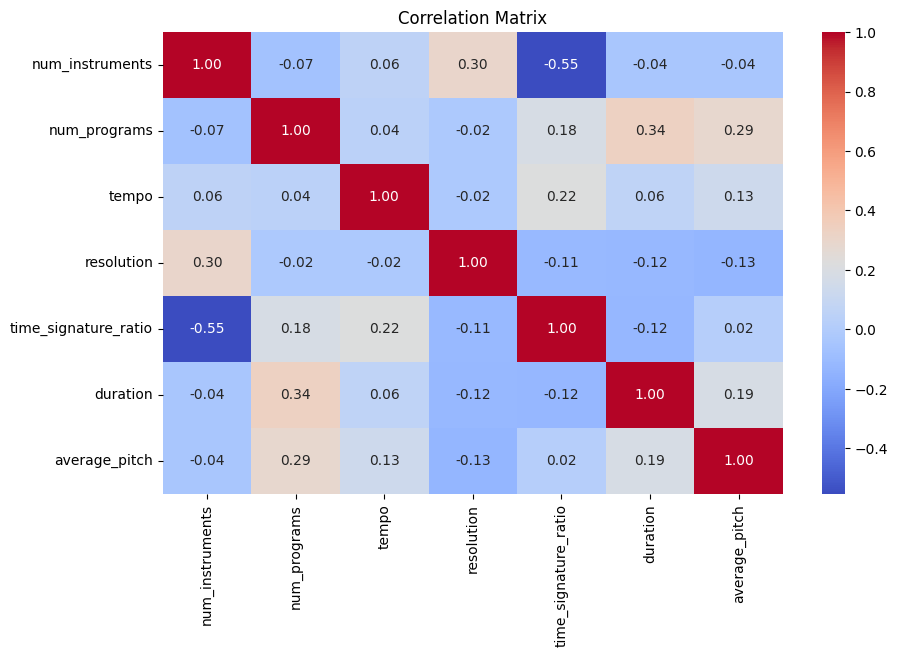

In [7]:
# Correlation Matrix
corr = df_clean[features].corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



# Normalization and Encoding

In [8]:
# Normalize the features using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])

# Display the first few rows of the normalized DataFrame
df_scaled.head()

label_encoder = LabelEncoder()
df_scaled['composer_encoded'] = label_encoder.fit_transform(df_scaled['composer'])

# Define the input features (X) and the target (y)
X = df_scaled[features].values
y = df_scaled['composer_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Approach A: CNN Model

In [9]:
# Import necessary libraries for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming that `df` and `df_scaled` are already defined as per your notebook
# Define the input features (X) and the target (y)
features = ['num_instruments', 'num_programs', 'tempo', 'resolution', 'time_signature_ratio', 'duration', 'average_pitch']
X = df_scaled[features].values
y = df_scaled['composer_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert the target to categorical
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50
6/6 [==============================] - 1s 37ms/step - loss: 2.1666 - accuracy: 0.2556 - val_loss: 2.1284 - val_accuracy: 0.2444
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 2.1097 - accuracy: 0.3833 - val_loss: 2.0684 - val_accuracy: 0.4444
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 2.0550 - accuracy: 0.4556 - val_loss: 2.0209 - val_accuracy: 0.4444
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 2.0024 - accuracy: 0.4944 - val_loss: 1.9750 - val_accuracy: 0.4444
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.9490 - accuracy: 0.5111 - val_loss: 1.9319 - val_accuracy: 0.4444
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.8955 - accuracy: 0.4833 - val_loss: 1.8762 - val_accuracy: 0.4444
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.8384 - accuracy: 0.4889 - val_loss: 1.8302 - val_accuracy: 0.4444
Epoch 8/50
6/6 [=================

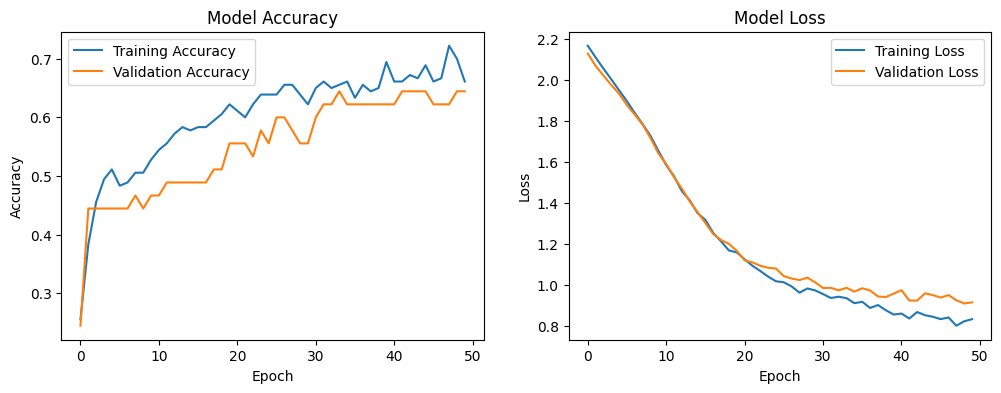

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.00      0.00      0.00         2
           2       0.80      1.00      0.89         8
           3       0.17      0.67      0.27         3
           4       0.00      0.00      0.00         1
           5       0.60      0.75      0.67         4
           6       0.00      0.00      0.00         6
           7       1.00      0.60      0.75         5
           8       0.60      0.75      0.67         4

    accuracy                           0.64        45
   macro avg       0.46      0.51      0.46        45
weighted avg       0.64      0.64      0.62        45



/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


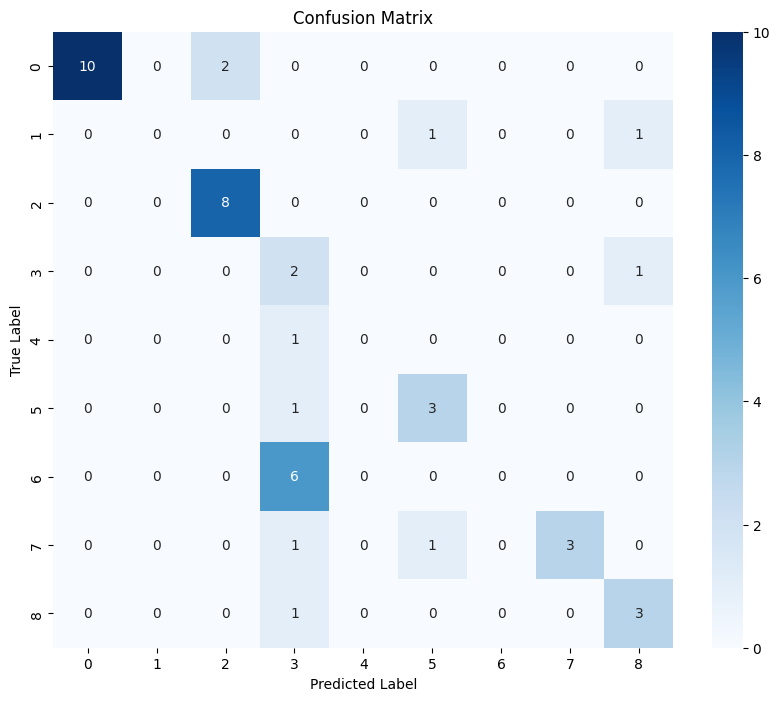

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_test.argmax(axis=-1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shapes of the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Class Weights: {class_weights}")

# Function for manual data augmentation
def add_noise(X, noise_factor=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0., 1.)

# Apply noise to training data
X_train_augmented = add_noise(X_train)

# Ensure y_train and y_test are one-hot encoded
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Reshape input data to 3D (batch size, steps, features)
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1)
X_test_scaled = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Check the shapes after reshaping
print(f"X_train_augmented shape: {X_train_augmented.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")

# Build a more complex model incrementally
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(X_train_augmented.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with class weights
history = model.fit(X_train_augmented, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_one_hot),
                    callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_one_hot)
print(f'Test Accuracy: {accuracy:.2f}')

X_train shape: (180, 7)
X_test shape: (45, 7)
y_train shape: (180,)
y_test shape: (45,)
Class Weights: {0: 0.7407407407407407, 1: 2.5, 2: 0.625, 3: 0.5882352941176471, 4: 2.857142857142857, 5: 1.5384615384615385, 6: 1.3333333333333333, 7: 0.8695652173913043, 8: 0.9523809523809523}
X_train_augmented shape: (180, 7, 1)
X_test_scaled shape: (45, 7, 1)
y_train_one_hot shape: (180, 9)
y_test_one_hot shape: (45, 9)
Epoch 1/100
6/6 [==============================] - 1s 44ms/step - loss: 5.8057 - accuracy: 0.1278 - val_loss: 4.7109 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 5.3233 - accuracy: 0.2278 - val_loss: 4.6556 - val_accuracy: 0.1556 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 4.5742 - accuracy: 0.3944 - val_loss: 4.6230 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 4.4786 - accuracy: 0.4333 - val_loss: 4.5941 - val_accuracy

# Approach B: RNN Model

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [23]:
# Define a function to create the LSTM model
def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 4),
        Dropout(dropout_rate),
        Dense(units // 8, activation='relu'),
        Dense(units // 16, activation='relu'),
        Dense(units // 32, activation='relu'),
        Dense(11, activation='softmax')
    ])
    return model

# Define the hyperparameters to tune
units = [2048]

# Define the dropout rates to tune
dropout_rates = [ 0.3]

# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize a list to store the results
results = []

# Loop through each combination of hyperparameters
for unit in units:
    for dropout_rate in dropout_rates:
        # Create the LSTM model
        model = create_lstm_model(unit, dropout_rate, input_shape)
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        accuracy = model.evaluate(X_train, y_train, verbose=0)
        accuracy_percentage = accuracy[1] * 100
        
        # Store the results
        results.append({
            'units': unit,
            'dropout_rate': dropout_rate,
            'accuracy': accuracy_percentage
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

# Storing variable for comparison later
history_rnn = history



C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.1089 - loss: 2.3921 - val_accuracy: 0.1389 - val_loss: 2.3467
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.2250 - loss: 2.3170 - val_accuracy: 0.1389 - val_loss: 2.0740
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.1907 - loss: 2.1424 - val_accuracy: 0.1389 - val_loss: 1.9904
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.1902 - loss: 2.0651 - val_accuracy: 0.1389 - val_loss: 1.9331
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1884 - loss: 1.8494 - val_accuracy: 0.3333 - val_loss: 1.8702
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.2368 - loss: 1.8269 - val_accuracy: 0.4167 - val_loss: 1.7767
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.3492 - loss: 1.7350 - val_accuracy: 0.3889 - val_loss: 1.5903
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.4157 - loss: 1.5984 - val_accuracy: 0.3333 - 

# Classification Report

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024C82C3B400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 817ms/step


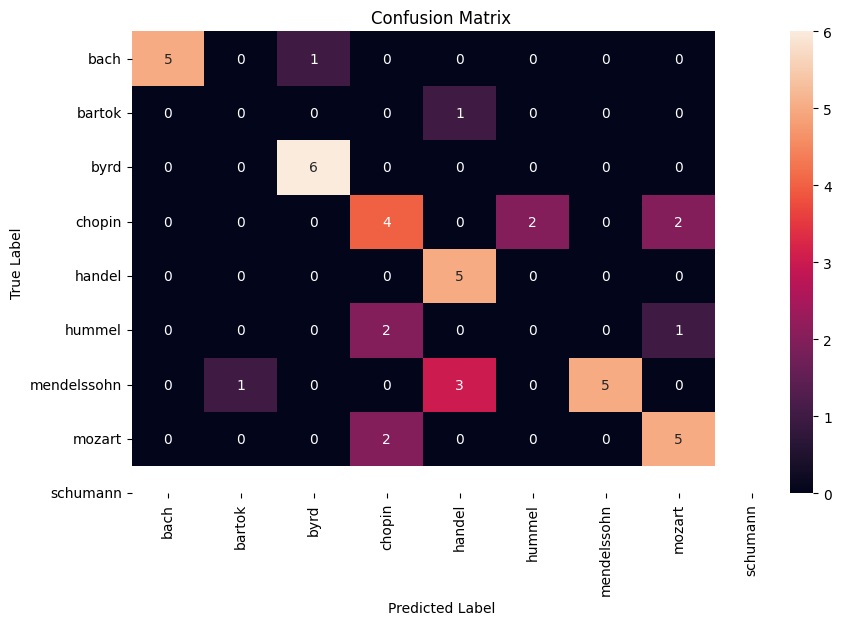

              precision    recall  f1-score   support

        bach       1.00      0.83      0.91         6
      bartok       0.00      0.00      0.00         1
        byrd       0.86      1.00      0.92         6
      chopin       0.50      0.50      0.50         8
      handel       0.56      1.00      0.71         5
      hummel       0.00      0.00      0.00         3
 mendelssohn       1.00      0.56      0.71         9
      mozart       0.62      0.71      0.67         7

    accuracy                           0.67        45
   macro avg       0.57      0.58      0.55        45
weighted avg       0.70      0.67      0.66        45



In [24]:
# predict the test data
y_pred = model.predict(X_test)

# Convert the predicted values to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report 
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_[:8]))


# Storing variable for later
cm_rnn = cm



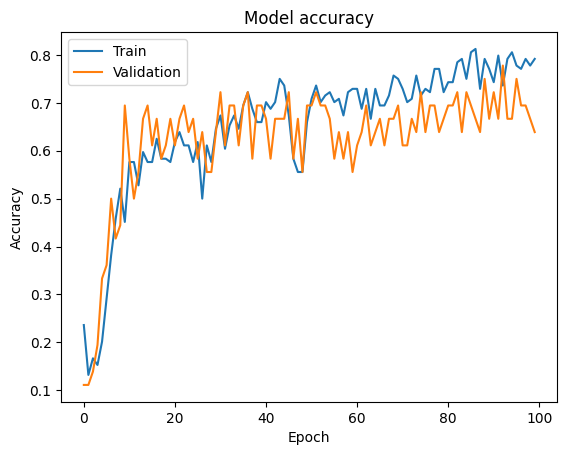

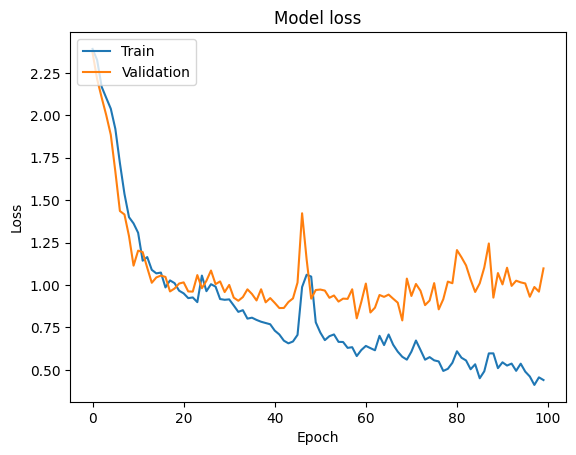

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Approach C: RNN + CNN Model

In [ ]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [19]:
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = Sequential([
    # CNN part - Adding another Conv1D and MaxPooling1D layer to make it deeper
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Conv1D(filters=128, kernel_size=1, activation='relu'),  # New Conv1D layer
    MaxPooling1D(pool_size=1),  # New MaxPooling1D layer
    
    # RNN part - Adding another LSTM layer to make it deeper
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # New LSTM layer
    Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)),
    
    # Fully connected part - Adding an additional dense layer
    Dense(units=256, activation='relu'),  # Increased units and added this layer
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(units=len(np.unique(y_train)), activation='softmax')
])

# Compile and train the model as before
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Save variable for later
histort_rnncnn = history


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 64)             512       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 128)            8320      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           263168    
 l)                                                              
                                                      

2/2 [==============================] - 0s 6ms/step - loss: 1.4452 - accuracy: 0.6889
Test accuracy: 0.6888889074325562
2/2 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.00      0.00      0.00         2
           2       0.89      1.00      0.94         8
           3       0.22      0.67      0.33         3
           4       0.00      0.00      0.00         1
           5       0.60      0.75      0.67         4
           6       0.50      0.17      0.25         6
           7       1.00      0.60      0.75         5
           8       0.60      0.75      0.67         4

    accuracy                           0.69        45
   macro avg       0.53      0.54      0.51        45
weighted avg       0.72      0.69      0.68        45



/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


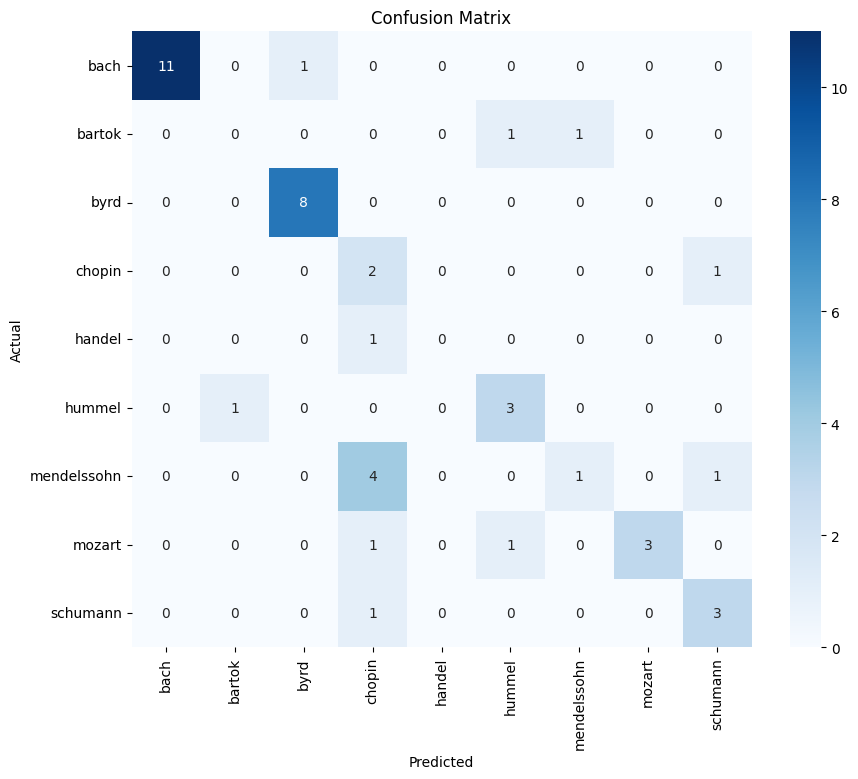

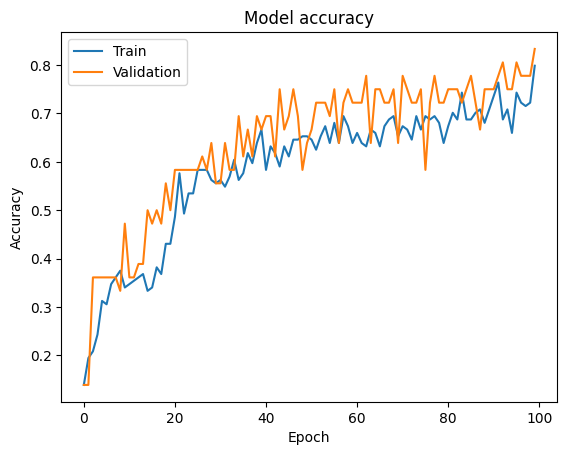

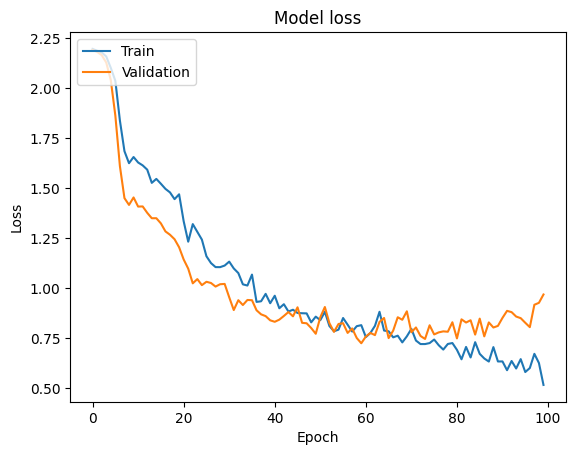

In [20]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [22]:
# Hyperparameter tuning

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def build_model(filters=64, kernel_size=1, pool_size=1, lstm_units=128, dense_units=256, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=pool_size),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),

        Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        Bidirectional(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)),

        Dense(units=dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(units=dense_units//2, activation='relu'),
        Dropout(dropout_rate),
        
        Dense(units=len(np.unique(y_train)), activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=1)

# Define the hyperparameter grid
param_dist = {
    'filters': [32, 64, 128],
    'kernel_size': [1, 3, 5],
    'pool_size': [1, 2],
    'lstm_units': [64, 128, 256],
    'dense_units': [128, 256, 512],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=3, verbose=1, n_jobs=-1)

# Perform the search
random_search_result = random_search.fit(X_train, y_train)

# Best hyperparameters and score
best_params = random_search_result.best_params_
best_score = random_search_result.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Score: ", best_score)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


/var/folders/d7/3y4pn1x55_583bts49jyqlxh0000gn/T/ipykernel_26228/364713415.py:41: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=1)


Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/150
Epoch 1/150
4/4 [==============================] - 29s 14ms/step - loss: 2.1956 - accuracy: 0.1417
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 2.1857 - accuracy: 0.2083
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 2.1718 - accuracy: 0.2083
Epoch 4/50
4/4 [==============================] - 29s 20ms/step - loss: 2.1947 - accuracy: 0.1000
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 2.1479 - accuracy: 0.2083
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 2.1809 - accuracy: 0.1500
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 2.1555 - accuracy: 0.1917
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 2.1828 - accuracy: 0.1917
Epoch 6/50
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 2.1018 - accuracy: 0.1333
Epoch 5/50
4/4 [===================

/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**s

Epoch 1/50
6/6 [==============================] - 13s 38ms/step - loss: 2.1909 - accuracy: 0.1833
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 2.1413 - accuracy: 0.1889
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 2.0338 - accuracy: 0.1611
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 1.9351 - accuracy: 0.2000
Epoch 5/50
6/6 [==============================] - 0s 34ms/step - loss: 1.7212 - accuracy: 0.3389
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 1.6302 - accuracy: 0.3389
Epoch 7/50
6/6 [==============================] - 0s 37ms/step - loss: 1.6065 - accuracy: 0.3778
Epoch 8/50
6/6 [==============================] - 0s 38ms/step - loss: 1.5022 - accuracy: 0.3556
Epoch 9/50
6/6 [==============================] - 0s 34ms/step - loss: 1.3948 - accuracy: 0.4222
Epoch 10/50
6/6 [==============================] - 0s 35ms/step - loss: 1.2943 - accuracy: 0.5056
Epoch 11/50
6/6 [===========

# Hyperparameter Tuning for RNN

In [29]:
# Adjusting Drop rate to 0.3 to improve the accuracy

# Define a function to create the LSTM model
def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 4),
        Dropout(dropout_rate),
        Dense(units // 8, activation='relu'),
        Dense(units // 16, activation='relu'),
        Dense(units // 32, activation='relu'),
        Dense(11, activation='softmax')
    ])
    return model

# Define the hyperparameters to tune
units = [2048]

# Define the dropout rates to tune
dropout_rates = [ 0.3]

# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize a list to store the results
results = []

# Loop through each combination of hyperparameters
for unit in units:
    for dropout_rate in dropout_rates:
        # Create the LSTM model
        model = create_lstm_model(unit, dropout_rate, input_shape)
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        accuracy = model.evaluate(X_train, y_train, verbose=0)
        accuracy_percentage = accuracy[1] * 100
        
        # Store the results
        results.append({
            'units': unit,
            'dropout_rate': dropout_rate,
            'accuracy': accuracy_percentage
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

# Storing variable for comparison later
history_rnn = history




C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.1124 - loss: 2.3951 - val_accuracy: 0.1944 - val_loss: 2.3683
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.1464 - loss: 2.3602 - val_accuracy: 0.1944 - val_loss: 2.1862
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.1671 - loss: 2.2020 - val_accuracy: 0.1389 - val_loss: 1.8778
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.1745 - loss: 2.1849 - val_accuracy: 0.1389 - val_loss: 1.9437
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.2179 - loss: 2.0365 - val_accuracy: 0.1389 - val_loss: 1.9478
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.2033 - loss: 1.9120 - val_accuracy: 0.1389 - val_loss: 1.8640
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.1564 - loss: 1.8335 - val_accuracy: 0.2778 - val_loss: 1.8242
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.2491 - loss: 1.7364 - val_accuracy: 0.3333 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


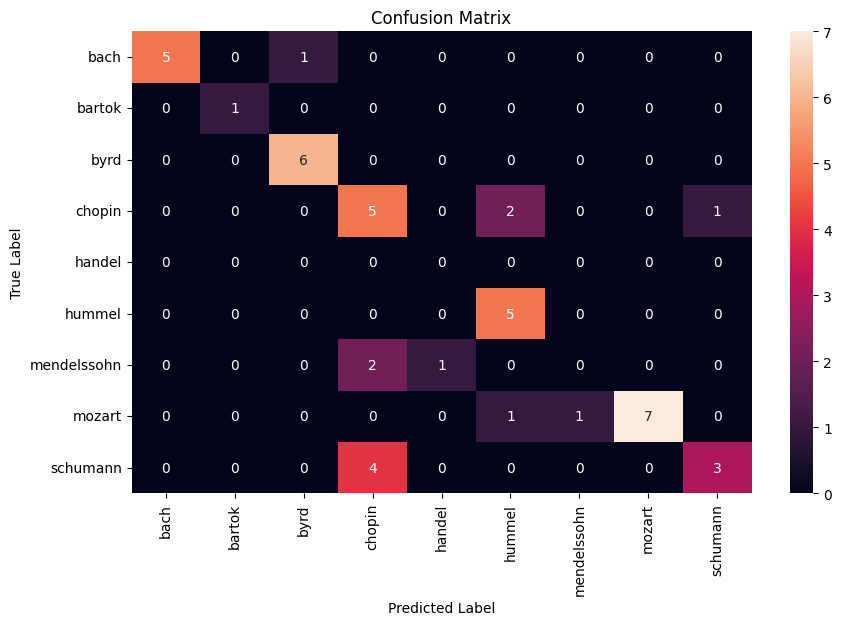

              precision    recall  f1-score   support

        bach       1.00      0.83      0.91         6
      bartok       1.00      1.00      1.00         1
        byrd       0.86      1.00      0.92         6
      chopin       0.45      0.62      0.53         8
      handel       0.00      0.00      0.00         0
      hummel       0.62      1.00      0.77         5
 mendelssohn       0.00      0.00      0.00         3
      mozart       1.00      0.78      0.88         9
    schumann       0.75      0.43      0.55         7

    accuracy                           0.71        45
   macro avg       0.63      0.63      0.62        45
weighted avg       0.74      0.71      0.71        45



C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

In [34]:
# predict the test data
y_pred = model.predict(X_test)

# Convert the predicted values to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Classification Report 
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))


# Storing variable for later
cm_rnn = cm



# Summary of Results

1. CNN Accuracy = 0.64
2. RNN Accuracy = 0.71
3. CNN + RNN Accuracy = 0.67